# 0.0 Decision Tree theory

![Terminology](Terminology.png)
![Gini](Gini.PNG)
  
**Gini impurity** is a measure of how often a randomly choosen element from the set would be incorrectly labeled if it was randomly labeled according to the distribution of labels in the subset.  

Example:  
Suppose you have a dataset of 10 samples:  
- Class A: 7 samples  
- Class B: 3 samples  

So the probabilities are:
$p_A = \frac{7}{10}$
$p_B = \frac{3}{10}$

So the Gini impurity is calculated as: $$G=1-\sum_{i=1}^{n} p_i^2$$ it is the same formula as $$\sum_{i=1}^{n} p_i(1-p_i)$$  

so for our case:  

$G = 1 - (0.7^2 + 0.3^2) = 0.42$

We are using Gini impurity for calculateing information gain, so first of all we are calculating impurity in the root node, then sub-nodes, and then we are able to compute information gain
![Gain](Gain.PNG)
Gain is calculated as impurity of the parent group - weighted average impurity of the child group

When we will calculated information gain of another rule of splitting we are able to choose which one is better (better = higher)
![Compare](Compare.PNG)
  
Another example:  
![Example](Example.PNG)


When we are using pruning and early stop condition?  
When we want to prevent a large numer of splits and overfitting

# 1.0 Generating datasets

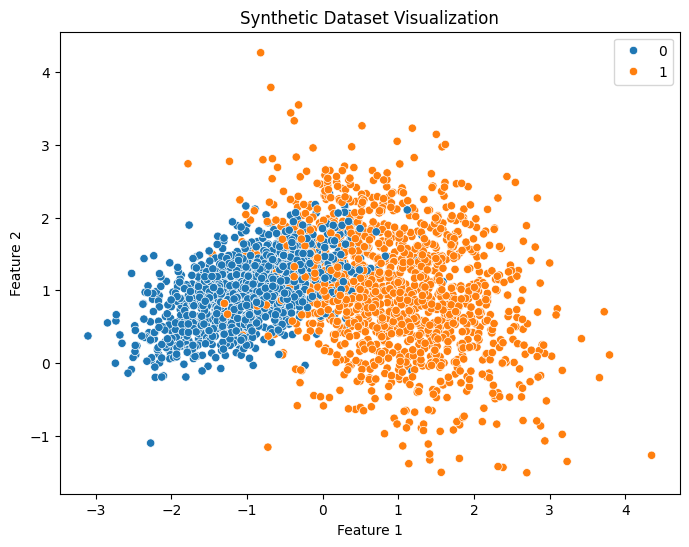

(array([[0.31636992, 0.52336586],
        [0.23333519, 0.55332919],
        [0.64023153, 0.51315327],
        ...,
        [0.32042662, 0.5744193 ],
        [0.38281779, 0.63056299],
        [0.25335978, 0.51857495]], shape=(2069, 2)),
 array([[0.49081402, 0.44213429],
        [0.52925269, 0.54282038],
        [0.52504841, 0.49777068],
        ...,
        [0.46406937, 0.66464009],
        [0.72069961, 0.66303562],
        [0.39211265, 0.50959685]], shape=(518, 2)))

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification, make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, roc_curve, auc
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import time

RANDOM_STATE = 254687
N_SAMPLES = 2587
N_FEATURES = 2
N_CLASSES = 2

class SyntheticDataset:
    """A class to generate and preprocess synthetic datasets for classification task."""

    def __init__(self, random_state: int, n_samples: int, n_features: int, n_classes: int, n_informative: int = N_FEATURES, n_clusters_per_class: int = 1, class_sep: float = 1):
        """
        Initialize the SyntheticDataset class.

        :param random_state: Seed for random number generation.
        :param n_samples: Number of samples to generate.
        :param n_features: Number of features for the dataset.
        :param n_classess: Number of classes for the target variable.
        """
        self.random_state = random_state
        self.n_samples = n_samples
        self.n_features = n_features
        self.n_classes = n_classes
        self.n_clusters_per_class = n_clusters_per_class
        self.class_sep = class_sep
        self.n_informative = n_informative
        self.X = None
        self.y = None
        self.X_train = None
        self.y_train = None
        self.X_test = None
        self.y_test = None


    def generate_make_classification(self) -> tuple[np.ndarray, np.ndarray]:
        """
        Generate a synthetic dataset using make_classification
        
        :return: A tuple containing the feature matrix (X) and target vector (y)
        """
        self.X, self.y = make_classification(
            n_samples=self.n_samples,
            n_features=self.n_features,
            n_informative=self.n_informative,
            n_redundant=0,
            n_clusters_per_class=self.n_clusters_per_class, # single-mod means one cluster per class
            random_state=self.random_state,
            class_sep=self.class_sep
            
        )
        return self.X, self.y
    
    def generate_make_moons(self) -> tuple[np.ndarray, np.ndarray]:
        """
        Generate a synthetic dataset using make_mmons

        :return: A tuple containing the feature matrix (X) and target vector (y)
        """
        self.X, self.y = make_moons(
            n_samples=self.n_samples,
            random_state=self.random_state,
        )
        return self.X, self.y

    def normalize(self) -> tuple[np.ndarray, np.ndarray]:
        """
        Normalize the feature matrix (X) and target vector(y) to the range [0,1].

        :return: A tuple containing the normalized feature matrix (X) and target vector (y)
 
        Note: 
        Remmber to fit only on training dataset so it means that I use min and max scaler on training dataset and
        then aplly this boudaries for test dataset. 
               """
        if self.X_train is not None and self.X_test is not None:
            min_x, max_x = self.X_train.min(), self.X_train.max() # Min, max taking only from training dataset
            self.X_train = (self.X_train - min_x) / (max_x - min_x)
            self.X_test = (self.X_test - min_x) / (max_x - min_x)

        return self.X_train, self.X_test 


    def visualize(self): 
        """ Visualize the dataset using a scatter plot"""
        if self.X is not None and self.y is not None:
            plt.figure(figsize=(8,6))
            sns.scatterplot(x=self.X[:,0], y=self.X[:,1], hue=self.y)
            plt.title("Synthetic Dataset Visualization")
            plt.xlabel("Feature 1")
            plt.ylabel("Feature 2")
            plt.show()
        else:
            print("Dataset not generated yet. Call generate() first.")


    
    def splitting(self) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        """Function for splitting datasets into training and test"""
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=0.2, random_state=RANDOM_STATE)
        return self.X_train, self.X_test, self.y_train, self.y_test

    
dataset = SyntheticDataset(RANDOM_STATE, N_SAMPLES, N_FEATURES, N_CLASSES, N_FEATURES)
dataset.generate_make_classification() 
dataset.visualize()

# Dividing dataset on a trening set and test set 
dataset.splitting()

# Normalization of datasets 
dataset.normalize()


# 1.1 Analyzes implementation

In [31]:
class ResultsAnalyzes:
    """ 
    A class to analyze and visualize the results of a binary classification model.

    Parameters:
        target (np.ndarray): The true labels.
        prediction (np.ndarray): The predicted labels.
    """

    def __init__(self, target: np.ndarray, prediction: np.ndarray):
        self.target = target
        self.prediction = prediction
        self._accuracy = None # Private atribute
        self._sensitivity = None
        self._specificity = None
        self._precision = None
        self._false_match_rate = None
        self._false_non_match_rate = None

    def confusion_matrix(self, ax=None, title="Confusion_matrix"):
        """
        Compute and plot the confusion matrix 
        
        Notes:
            gca() stands for "get current axes". If no axes exists it creates one automatically. 
        """
        cm = confusion_matrix(self.target, self.prediction)

        if ax is None:
            # Plot the confusion matrix using Seaborn
            plt.figure(figsize=(6,4))
            ax = plt.gca()

        sns.heatmap(
            cm, 
            annot=True, # Displays the value in each cell
            fmt="d", # Format the values as integers
            cmap="Blues", # uses a blue color palette 
            cbar=False, # Hide the color bar
            xticklabels=["Predcited 0", "Predicted 1"],
            yticklabels=["Actual 0", "Actual 1"],
            ax=ax
        )
        
        
        ax.set_xlabel("Predicted Label")
        ax.set_ylabel("True Label")
        ax.set_title(title)
        
        if ax is None:
            plt.show()

    @property 
    def accuracy(self) -> float:
        """ 
        Compute the accuracy of the predictions.
        
        Notes:
            Tells how many samples were well classified from all samples
        """
        return accuracy_score(self.target, self.prediction) 

    @property
    def sensitivity(self) -> float: 
        """ 
        Compute the sensivitty (recall) of the predictions. Sensitivity (Recall) = TP / (TP + FN) 
        
        Notes:
            Tell how many samples were predicted as True Positive from all Acutal Positive
        """
        
        return recall_score(self.target, self.prediction)

    @property
    def specificity(self) -> float: 
        """
        Compute the specificity of the predictions.  Specificity = TN / (TN + FP)

        Notes:
            Tell how many samples were predicted as True Negatives from all Acutal Negative
        """
        
        cm = confusion_matrix(self.target, self.prediction)
        self.tn, self.fp, self.fn, self.tp = cm.ravel() # ravel function in numpy is used to faltten a multi-dimensional array into a 1-dimensional array. It returns a contiguous flattened array, meaning it 
        # collapses the array into a single dimension while maintaining the order of the elements 
        specificity = self.tn / (self.tn + self.fp)
        return specificity
    
    @property
    def balanced_accuracy(self) -> float:
        """
        Compute class imbalance by giving equal weight to both classes.

        Notes:  
         Useful when:
        - Model detects one class better than the other
        - Dataset has unequal class distribution

        !!!! high BA doesn't reveal if the model beats majority-class guessing
        example: in a 90% majority classs, BA = 0.9 could mean the model just predicts the majority that's why we need J score

        **Interpretation:**  
        - 1 = Perfect classifier  
        - 0.5 = Random guessing  
        
        """
        return (self.sensitivity + self.specificity) / 2
    
    @property
    def j_score(self) -> float:
        """
        Measures how much better the model is than random chance. Penalizes models that rely on class imbalance. 

        Notes:
        baseline = 0 means no better than guessing
        J = 0.6 means the model is 60% better than random
        J = -1 means always wrong
        J = 1 means perfect
        """
        return self.sensitivity + self.specificity - 1
    

    @property
    def f1_score(self) -> float:
        """
        Is a critical metric for evaluating classification models, especially when dealing with imbalanced datasets. 
        Penalizes models that ignore the minority class
        Use case: 
        Ideal for fraud detecion, disease screening:
        * In fraud detection: it answers: "Are we catching enough fraud without overwhelming our team?
        * In disease screening "Are we diagnosing patients early without causing unnecessary panic?
        """
        return f1_score(self.target, self.prediction)
    

    @property
    def false_match_rate(self) -> float:
        """
        This metric is critical in biometric systems (e.g., fingerprint, face recognition) and security applications. 
        Mistaking an impostor for a legitimate user.
        
        Notes:
        Lower FMR → Stricter system (fewer impostors accepted, but more legitimate users rejected).
        A bank vault prioritizes low FMR (avoid impostors) → High FNMR is tolerated (owners may retry).
        """
        return self.fp / (self.fp + self.tn)
    

    @property
    def false_non_match_rate(self) -> float:
        """
        This metric is critical in biometric systems (e.g., fingerprint, face recognition) and security applications. 
        Mistaking a legitimate user for an impostor. \
        
        Notes:
        A office door prioritizes low FNMR (avoid frustrating employees) → Higher FMR risk.       
        """
        return self.fn / (self.fn + self.tp)
    

    def show_results(self):
        """ Display the accuracy, sensitivity and specificity of the predictions"""
        #self.accuracy = self._accuracy()
        #self.sensitivity = self._sensitivity()
        #self.specificity = self._specificity()
        print(f"Accuracy: {self.accuracy:.2f}, Sensivity: {self.sensitivity:.2f}, Specifity: {self.specificity:.2f}")

    
    def plot_ROC_curve(self, y_prediction_probability: np.ndarray, ax=None, title="ROC curve"):
        """
        Plot the Receiver Operaint Characteristic (ROC) curve.
        
        Parameters:
            y_prediction_probability (np.ndarray): The predicted probabilities for the positive class.
        """
        # Compute ORC curve and AUC
        fpr, tpr, thresholds = roc_curve(self.target, y_prediction_probability) # stands for False Positive Rate (1 - Specificity)  and True Positive Rate (Sensitivity)
        roc_auc = auc(fpr, tpr)

        # Plot ROC curve
        if ax is None:
            plt.figure(figsize=(8,6))
            ax = plt.gca()
        ax.plot(fpr, tpr, color="blue", lw=2, label=f"ROC cruve (AUC = {roc_auc:.2f})")
        ax.set_xlabel("False Positive Rate")
        ax.set_ylabel("True Positive Rate")
        ax.set_title(title)
        ax.legend(loc="lower right")
        
        if ax is None:
            plt.show()

        def plot_decision_boundary(self, X: np.ndarray, y: np.ndarray):
            """
            Plot the decision boundary for a trained model.
            
            Parameters:
                X (np.ndarray): The feature matrix of shape (n_samples,n_features)
                y (np.ndarray): The target vector of shape (n_samples,).
            """

            if X.shape[1] != 2:
                raise ValueError("Decision boundary plotting is only supported for 2D feature spaces.")
            
            # Create a grid of points covering the feature space
            x_min, x_max = X[:,0].min() - 1, X[:,0].max() + 1 # Frist feature
            y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1 # Second feature

# 2.0 Implementation of decision tree

In [ ]:
from typing import Optional, Union, Dict, Tuple, Any

class Node():

    """A node in a decision tree."""
    def __init__(
        self,
        *, 
        feature_index: Optional[int] = None,
        threshold : Optional[Union[float, int]] = None,
        left: Optional['Node'] = None, 
        right: Optional['Node'] = None, 
        info_gain: Optional[float] = None, 
        value: Optional[Union[float, int]] = None):

        """ Initialize a decision tree.
        Args:
            feature_index: Index of the feature used for splitting
            threshold: threshold value for the feature split.
            left: Left child node.
            right: Right child node.
            info_gain: Information gain from the split.
            value: Predicted value if this is a leaf node.
        """

        # Split atributes
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right 
        self.info_gain = info_gain
        
        # Leaf atributes
        self.value = value
        self.class_distribution = None # For probability estimates
        self.leaf_classes = None
        

class DecisionTree():
    """ A decision tree classifier.
    
    Attributes: 
        root: The root node of the decision tree.
        max_depth: Maximum depth of the tree.
        min_samples_split: Minimum number of samples required to split a node.
    """

    def __init__(self, max_depth: int, min_samples_split: int = 2) -> None:
        """Initialize the decision tree with stopping condtinions
        
        Args:
            max_depth: Maximum depth the tree can grow.
            min_samples_split: Minimum samples needed to split a Node. Defaults to 2.
        """
        self.root: Optional[Node] = None
        self.max_depth: int = max_depth
        self.min_samples_split: int = min_samples_split


    def build_tree(self, dataset: np.ndarray, current_depth: int = 0) -> Node:
        """Recursively builds the decision tree.
        
        Args: 
            dataset: The numpy array of samples
            current_depth: Current depth in the three. Defaults to 0.
        
        Returns:
            Node: The root node of the constructed subtree.

        Notes: 
            Why we are checking > 0 ?. Because when info_gain = 0, it means splitting the node didn't improve class separation, this happens in two
            scenarios:
                - all samples already belong to the same class (pure node)
                - the split didn't separate classes better than the parent node
            Pay attention that thanks to recursive there all left subtrees will be done and ther all right
        """
        X, y = dataset[:,:-1], dataset[:,-1]
        num_samples, num_features = np.shape(X)

        # Check stopping conditions
        if num_samples >= self.min_samples_split and (self.max_depth is None or current_depth <= self.max_depth):
            
            best_split = self.get_best_split(dataset, num_samples, num_features)
            
            if best_split["info_gain"] > 0: 

                left_subtree = self.build_tree(best_split["dataset_left"], current_depth + 1)
                right_subtree = self.build_tree(best_split["dataset_right"], current_depth + 1)
                return Node(
                    feature_index=best_split["feature_index"],
                    threshold=best_split["threshold"],
                    left=left_subtree, 
                    right=right_subtree, 
                    info_gain=best_split["info_gain"]
                )
            
        leaf_value = self.calculate_leaf_value(y)
        
        # Creating leaf node
        node = Node(value=leaf_value)

        # Store class distribution
        classes, counts = np.unique(y, return_counts=True)
        node.class_distribution = counts / counts.sum()
        node.leaf_classes = classes 

        # if self.classes_ doesn't exists (first leaf) initializes it with the classes found in this leaf 
        # if self.classes_ exists combines existing classes with new ones from this leaf, unique values to avoid duplicates
        self.classes_ = np.unique(np.concatenate([self.classes_, classes])) if hasattr(self, 'classes_') else classes

        return node
    
    
    def get_best_split(self, dataset: np.ndarray, num_samples: int, num_features: int) -> Dict[str, Any]:
        """Find the optimal split for a dataset using a information gain.
        
        Args:
            dataset: Input data
            num_samples: Number of samples in the dataset
            num_features: Number of features in the dataset

        Returns:
            Dictioniary containing:
                -feature_index: Best feature to split on
                -threshold: Best threshold value
                -dataset_left: Left subset
                -dataset_right: Right subset
                -info_gain: Information gain of this split
        """

        best_split = {}
        max_info_gain = -float("inf") # We wanna maximize information gain

        for feature_index in range (num_features):
            
            feature_values = dataset[:, feature_index]
            # iterować krokiem jesli chodzi o mozliwe progi
            possible_tresholds = np.unique(feature_values)

            for threshold in possible_tresholds:

                dataset_left, dataset_right = self.split(dataset, feature_index, threshold)
                if len(dataset_left) > 0 and len(dataset_right) > 0:

                    y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
                    curr_info_gain = self.information_gain(y, left_y, right_y)
                    if curr_info_gain > max_info_gain:

                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["info_gain"] = curr_info_gain
                        max_info_gain = curr_info_gain

        return best_split
    

    def split(self, dataset: np.ndarray, feature_index: int, threshold: float) -> Tuple[np.ndarray, np.ndarray]:
        """Split dataset based on feature treshold.
        
        Args:
            dataset: input data to split.
            feature_index: index of feature to split on
            threshold: Value to split the feature

        Returns:
            Tuple of (left_subtree, right_subtree)
        """
        # dataset_left = np.array([row for row in dataset if row[feature_index] <= threshold])
        # dataset_right = np.array([row for row in dataset if row[feature_index] > threshold])

        feature_column = dataset[:, feature_index]
        dataset_left = dataset[feature_column <= threshold]
        dataset_right = dataset[feature_column > threshold]
        return dataset_left, dataset_right
    

    def information_gain(self, parent: np.ndarray, l_child: np.ndarray, r_child: np.ndarray):
        """Calculates the information gain from a potential split.
        
        Args:
            parent: Parent node target values
            l_child: Left child node target values
            r_child: Right child node target values

        Returns:
            The information gain
        """
        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)
        gain = self.entropy(parent) - (weight_l * self.entropy(l_child) + weight_r * self.entropy(r_child))
        return gain
    

    def entropy(self, y: np.ndarray):
        """Calculates the entropy of a target value distribution    
        
        Args:
            y: Array of taget values
        
        Returns:
            The computed entropy value.
        """
        class_labels, counts = np.unique(y, return_counts=True)
        probabilities = counts / len(y)
        entropy = -np.sum(probabilities* np.log2(probabilities + 1e-10)) # Added epsilon for numerical stability
        return entropy
    

    def calculate_leaf_value(self, y: np.ndarray) -> Union[int, float]:
        """Determines the prediciton value for a leaf node
        
        Args:
            y: Target values at the leaf node.

        Returns:
            The most frequent class
        """
        values, counts = np.unique(y, return_counts=True)
        return values[np.argmax(counts)]
    
        
    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        """Builds the decision tree from the training data.
        
        Args:
            X: Training data of shape n_features x n_samples
            y: Target values of shape (n_samples, )

        Raises:
            ValueError: If X and y have incompatible shapes
        """

        if X.shape[0] != y.shape[0]:
            raise ValueError("X and y must have the same number of samples")
        
        self.classes_ = np.unique(y)
        y_reshaped = y.reshape(-1, 1) if y.ndim == 1 else y
        dataset = np.concatenate((X, y_reshaped), axis=1)
        self.root = self.build_tree(dataset)


    def predict(self, X: np.ndarray):
        """Predicts target values for the input features
        
        Args:
            X: Input features of shape (n_samples, n_features)

        Returns:
            Array of predicted values
        """

        if self.root is None:
            raise RuntimeError("The three has not been fitted yet. Call 'fit' first.")
        
        proba = self.predict_proba(X)
        return np.array([self.classes_[np.argmax(p)] for p in proba])

    
    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        """Predict class probabilities for samples in X.
        
        Args:
            X: input features of shape (n_samples, n_features)

        Returns:
            Array of probabilities (shape: (n_samples, n_classes))

        """
        if self.root is None:
            raise RuntimeError("The tree has not been fitted yet.")
        
        # Initialize array of zeros
        proba = np.zeros((X.shape[0], len(self.classes_)))

        for i, x in enumerate(X):
            node = self.root

            while True:
                if node.value is not None: # Reached leaf node
                    # Create probability vector aligned with self.classes_
                    leaf_proba = np.zeros(len(self.classes_))
                    if node.class_distribution is not None:
                        for cls, prob in zip(node.leaf_classes, node.class_distribution):
                            class_idx = np.where(self.classes_ == cls)[0][0]
                            leaf_proba[class_idx] = prob
                    proba[i] = leaf_proba
                    break
                feature_val = x[node.feature_index]
                node = node.left if feature_val <= node.threshold else node.right

        return proba


    # def _make_predictions(self, x: np.ndarray, tree: Optional[Node]) -> Union[float, int]:
    #     """Recursively traverses the decision tree to make a prediction for a single sample
        
    #     Args:
    #         x: Input feature vector of shape (n_features, )
    #         tree: Current n
    #     """
    #     # For leaf nodes, return the class distribution
    #     if tree.value != None: 
    #         classes = np.unique(self.classes_)

    #         return tree.value
    #     feature_val = x[tree.feature_index]
    #     if feature_val <= tree.threshold:
    #         return self._make_predictions(x, tree.left)
    #     else:
    #         return self._make_predictions(x, tree.right)



# 3.0 Checking results on datasets

## 3.1. Make classification

### 3.1.1. Depth of tree = n_features

Own Algorithm took 0.42 sec
Sklearn Algorithm took 0.01 sec


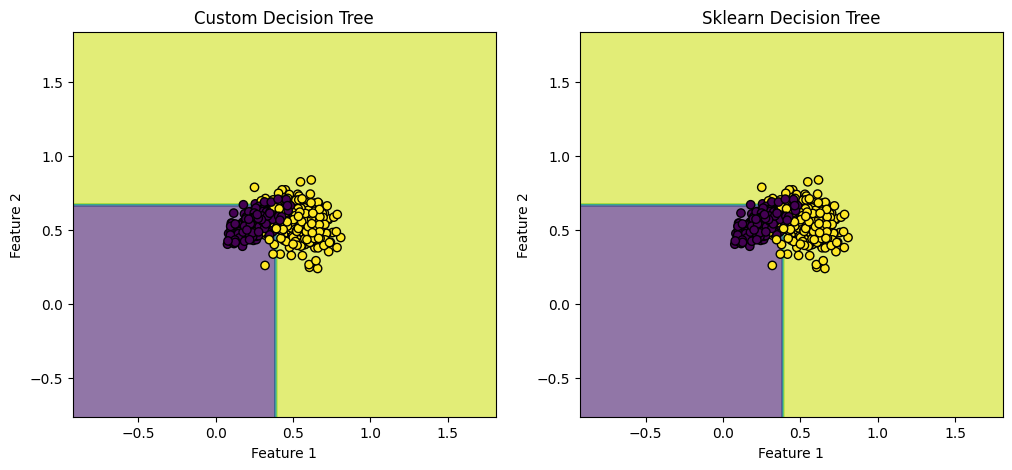

Own implementation results:
Accuracy: 0.89, Sensivity: 0.95, Specifity: 0.84
Sklearn implementation results:
Accuracy: 0.89, Sensivity: 0.95, Specifity: 0.84


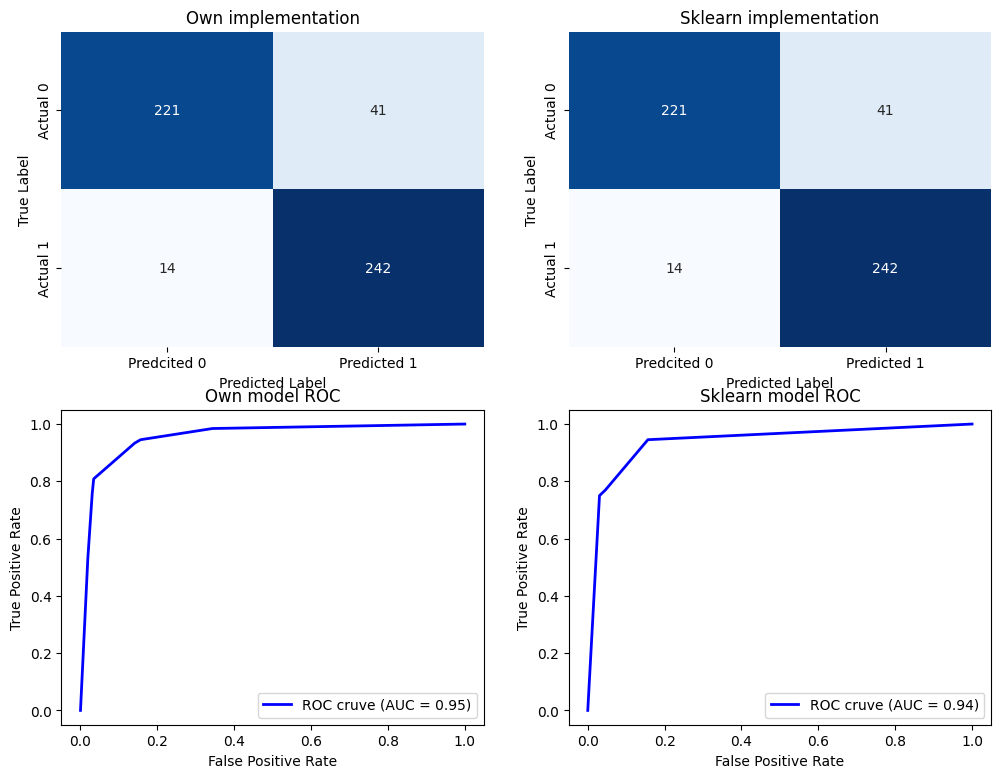

In [33]:
from sklearn.tree import DecisionTreeClassifier
from matplotlib.gridspec import GridSpec

# Fitting models
sklearn_tree_clf = DecisionTreeClassifier(criterion='log_loss', max_depth=2)
sklearn_tree_clf.fit(dataset.X_train, dataset.y_train)

tree_clf = DecisionTree(max_depth=2)
tree_clf.fit(dataset.X_train, dataset.y_train)

# Own algorithm 
start_time = time.time()
for _ in range(100):
    y_pred = tree_clf.predict(dataset.X_test)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Own Algorithm took {elapsed_time:.2f} sec")
y_proba = tree_clf.predict_proba(dataset.X_test)[:, 1]

# Sklearn algorithm
start_time = time.time()
for _ in range(100):
    y_pred_sklearn = sklearn_tree_clf.predict(dataset.X_test)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Sklearn Algorithm took {elapsed_time:.2f} sec")
y_proba_sklearn = sklearn_tree_clf.predict_proba(dataset.X_test)[:, 1]


# Range of features
x_min, x_max = dataset.X_test[:,0].min() - 1, dataset.X_test[:,0].max() + 1 
y_min, y_max = dataset.X_test[:,1].min() - 1, dataset.X_test[:,1].max() + 1

# Creating mesh grid
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

# Flatten a mesh grid
grid_points = np.c_[xx.ravel(), yy.ravel()]

# Prediction for every point of the grid, own algorithm
Z = tree_clf.predict(grid_points)
Z = Z.reshape(xx.shape)

# Prediction for every point of the grid, sklearn algorithm
Z_sklearn = sklearn_tree_clf.predict(grid_points)
Z_sklearn = Z_sklearn.reshape(xx.shape)

# Create a figure with two subplots side by side
fig = plt.figure(figsize=(12, 5))
gs = GridSpec(1, 2, figure=fig)

# Plot own Decision Tree
ax1 = fig.add_subplot(gs[0, 0])
contour1 = ax1.contourf(xx, yy, Z, cmap="viridis", alpha=0.6)
scatter1 = ax1.scatter(dataset.X_test[:, 0], dataset.X_test[:, 1], c=dataset.y_test, cmap="viridis", edgecolor='k')
ax1.set_xlabel("Feature 1")
ax1.set_ylabel("Feature 2")
ax1.set_title("Custom Decision Tree")

# Plot sklearn Decision Tree
ax2 = fig.add_subplot(gs[0, 1])
contour2 = ax2.contourf(xx, yy, Z_sklearn, cmap="viridis", alpha=0.6)
scatter2 = ax2.scatter(dataset.X_test[:, 0], dataset.X_test[:, 1], c=dataset.y_test, cmap="viridis", edgecolor='k')
ax2.set_xlabel("Feature 1")
ax2.set_ylabel("Feature 2")
ax2.set_title("Sklearn Decision Tree")

plt.show()


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,9))

# Own analyzer
analyzer = ResultsAnalyzes(dataset.y_test, y_pred)
print("Own implementation results:")
analyzer.show_results()
analyzer.confusion_matrix(ax=ax1, title="Own implementation")
analyzer.plot_ROC_curve(y_proba, ax=ax3, title="Own model ROC")

# Sklearn analyzer
analyzer_sklearn = ResultsAnalyzes(dataset.y_test, y_pred_sklearn)
print("Sklearn implementation results:")
analyzer_sklearn.show_results()
analyzer_sklearn.confusion_matrix(ax=ax2, title="Sklearn implementation")
analyzer_sklearn.plot_ROC_curve(y_proba_sklearn, ax=ax4, title="Sklearn model ROC")

### 3.1.2. Depth of tree = n_clusters

Own Algorithm took 0.40 sec
Sklearn Algorithm took 0.01 sec


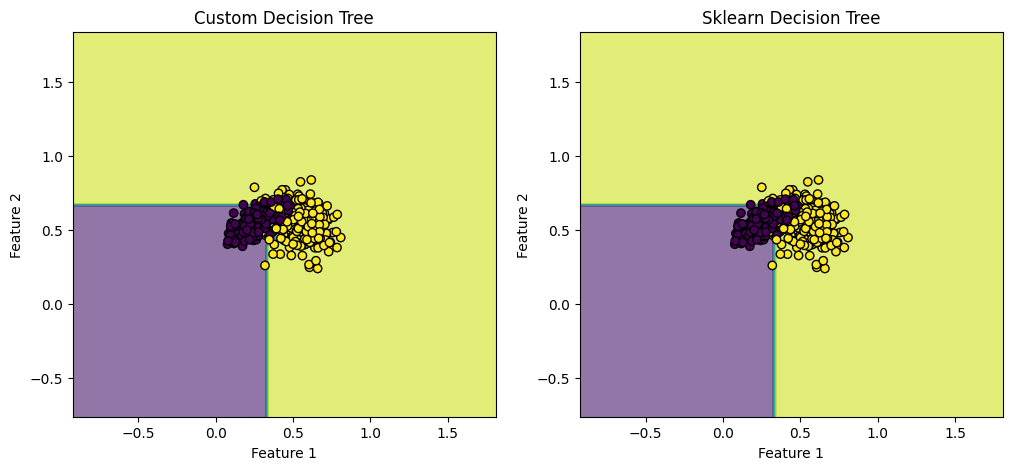

Own implementation results:
Accuracy: 0.90, Sensivity: 0.84, Specifity: 0.96
Sklearn implementation results:
Accuracy: 0.90, Sensivity: 0.85, Specifity: 0.94


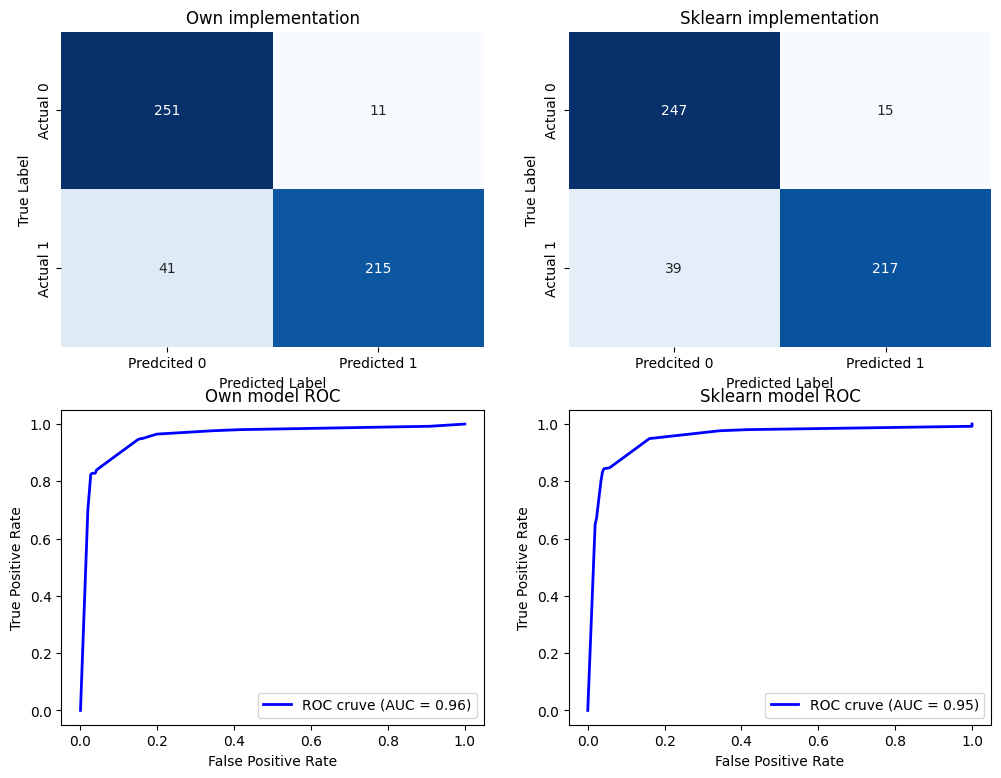

In [34]:
# Fitting models
sklearn_tree_clf = DecisionTreeClassifier(criterion='log_loss', max_depth=4)
sklearn_tree_clf.fit(dataset.X_train, dataset.y_train)

tree_clf = DecisionTree(max_depth=4)
tree_clf.fit(dataset.X_train, dataset.y_train)

# Own algorithm 
start_time = time.time()
for _ in range(100):
    y_pred = tree_clf.predict(dataset.X_test)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Own Algorithm took {elapsed_time:.2f} sec")
y_proba = tree_clf.predict_proba(dataset.X_test)[:, 1]

# Sklearn algorithm
start_time = time.time()
for _ in range(100):
    y_pred_sklearn = sklearn_tree_clf.predict(dataset.X_test)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Sklearn Algorithm took {elapsed_time:.2f} sec")
y_proba_sklearn = sklearn_tree_clf.predict_proba(dataset.X_test)[:, 1]


# Range of features
x_min, x_max = dataset.X_test[:,0].min() - 1, dataset.X_test[:,0].max() + 1 
y_min, y_max = dataset.X_test[:,1].min() - 1, dataset.X_test[:,1].max() + 1

# Creating mesh grid
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

# Flatten a mesh grid
grid_points = np.c_[xx.ravel(), yy.ravel()]

# Prediction for every point of the grid, own algorithm
Z = tree_clf.predict(grid_points)
Z = Z.reshape(xx.shape)

# Prediction for every point of the grid, sklearn algorithm
Z_sklearn = sklearn_tree_clf.predict(grid_points)
Z_sklearn = Z_sklearn.reshape(xx.shape)

# Create a figure with two subplots side by side
fig = plt.figure(figsize=(12, 5))
gs = GridSpec(1, 2, figure=fig)

# Plot own Decision Tree
ax1 = fig.add_subplot(gs[0, 0])
contour1 = ax1.contourf(xx, yy, Z, cmap="viridis", alpha=0.6)
scatter1 = ax1.scatter(dataset.X_test[:, 0], dataset.X_test[:, 1], c=dataset.y_test, cmap="viridis", edgecolor='k')
ax1.set_xlabel("Feature 1")
ax1.set_ylabel("Feature 2")
ax1.set_title("Custom Decision Tree")

# Plot sklearn Decision Tree
ax2 = fig.add_subplot(gs[0, 1])
contour2 = ax2.contourf(xx, yy, Z_sklearn, cmap="viridis", alpha=0.6)
scatter2 = ax2.scatter(dataset.X_test[:, 0], dataset.X_test[:, 1], c=dataset.y_test, cmap="viridis", edgecolor='k')
ax2.set_xlabel("Feature 1")
ax2.set_ylabel("Feature 2")
ax2.set_title("Sklearn Decision Tree")

plt.show()


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,9))

# Own analyzer
analyzer = ResultsAnalyzes(dataset.y_test, y_pred)
print("Own implementation results:")
analyzer.show_results()
analyzer.confusion_matrix(ax=ax1, title="Own implementation")
analyzer.plot_ROC_curve(y_proba, ax=ax3, title="Own model ROC")

# Sklearn analyzer
analyzer_sklearn = ResultsAnalyzes(dataset.y_test, y_pred_sklearn)
print("Sklearn implementation results:")
analyzer_sklearn.show_results()
analyzer_sklearn.confusion_matrix(ax=ax2, title="Sklearn implementation")
analyzer_sklearn.plot_ROC_curve(y_proba_sklearn, ax=ax4, title="Sklearn model ROC")

### 3.1.3. Depth of tree = non limited

Own Algorithm took 0.41 sec
Sklearn Algorithm took 0.01 sec


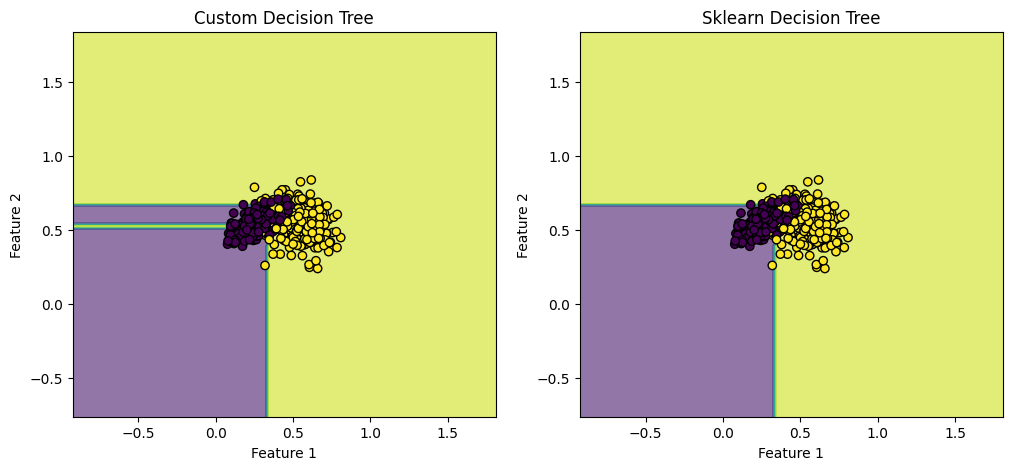

Own implementation results:
Accuracy: 0.88, Sensivity: 0.90, Specifity: 0.85
Sklearn implementation results:
Accuracy: 0.87, Sensivity: 0.91, Specifity: 0.84


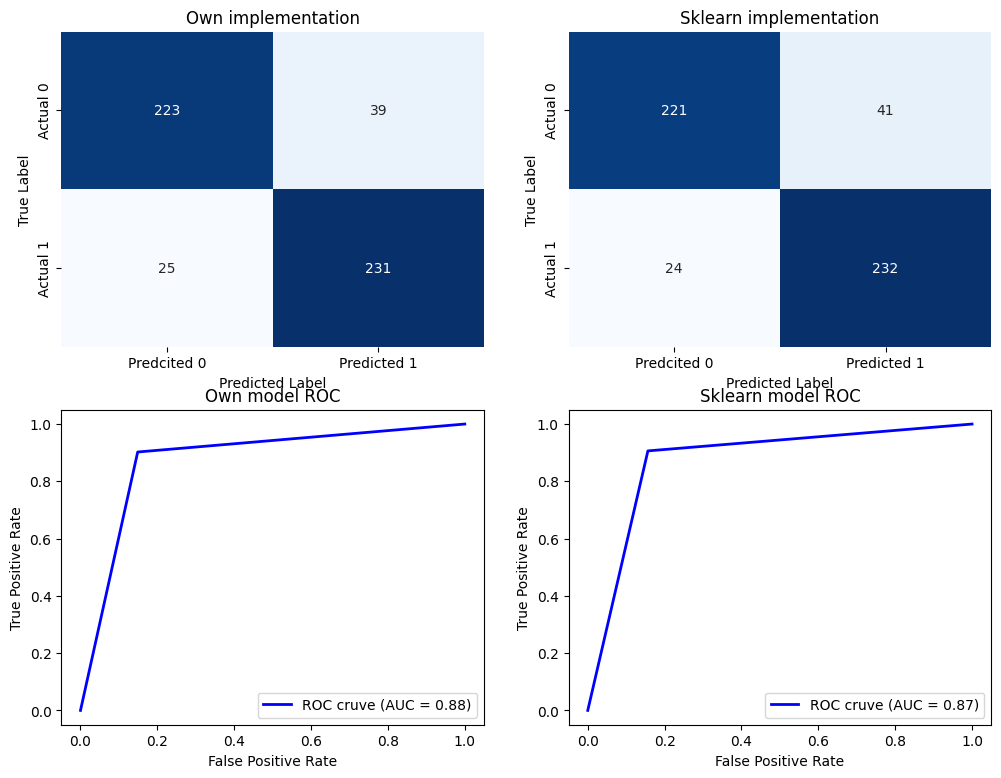

In [35]:
# Fitting models
sklearn_tree_clf = DecisionTreeClassifier(criterion='log_loss', max_depth=None)
sklearn_tree_clf.fit(dataset.X_train, dataset.y_train)

tree_clf = DecisionTree(max_depth=None)
tree_clf.fit(dataset.X_train, dataset.y_train)

# Own algorithm 
start_time = time.time()
for _ in range(100):
    y_pred = tree_clf.predict(dataset.X_test)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Own Algorithm took {elapsed_time:.2f} sec")
y_proba = tree_clf.predict_proba(dataset.X_test)[:, 1]

# Sklearn algorithm
start_time = time.time()
for _ in range(100):
    y_pred_sklearn = sklearn_tree_clf.predict(dataset.X_test)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Sklearn Algorithm took {elapsed_time:.2f} sec")
y_proba_sklearn = sklearn_tree_clf.predict_proba(dataset.X_test)[:, 1]


# Range of features
x_min, x_max = dataset.X_test[:,0].min() - 1, dataset.X_test[:,0].max() + 1 
y_min, y_max = dataset.X_test[:,1].min() - 1, dataset.X_test[:,1].max() + 1

# Creating mesh grid
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

# Flatten a mesh grid
grid_points = np.c_[xx.ravel(), yy.ravel()]

# Prediction for every point of the grid, own algorithm
Z = tree_clf.predict(grid_points)
Z = Z.reshape(xx.shape)

# Prediction for every point of the grid, sklearn algorithm
Z_sklearn = sklearn_tree_clf.predict(grid_points)
Z_sklearn = Z_sklearn.reshape(xx.shape)

# Create a figure with two subplots side by side
fig = plt.figure(figsize=(12, 5))
gs = GridSpec(1, 2, figure=fig)

# Plot own Decision Tree
ax1 = fig.add_subplot(gs[0, 0])
contour1 = ax1.contourf(xx, yy, Z, cmap="viridis", alpha=0.6)
scatter1 = ax1.scatter(dataset.X_test[:, 0], dataset.X_test[:, 1], c=dataset.y_test, cmap="viridis", edgecolor='k')
ax1.set_xlabel("Feature 1")
ax1.set_ylabel("Feature 2")
ax1.set_title("Custom Decision Tree")

# Plot sklearn Decision Tree
ax2 = fig.add_subplot(gs[0, 1])
contour2 = ax2.contourf(xx, yy, Z_sklearn, cmap="viridis", alpha=0.6)
scatter2 = ax2.scatter(dataset.X_test[:, 0], dataset.X_test[:, 1], c=dataset.y_test, cmap="viridis", edgecolor='k')
ax2.set_xlabel("Feature 1")
ax2.set_ylabel("Feature 2")
ax2.set_title("Sklearn Decision Tree")

plt.show()


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,9))

# Own analyzer
analyzer = ResultsAnalyzes(dataset.y_test, y_pred)
print("Own implementation results:")
analyzer.show_results()
analyzer.confusion_matrix(ax=ax1, title="Own implementation")
analyzer.plot_ROC_curve(y_proba, ax=ax3, title="Own model ROC")

# Sklearn analyzer
analyzer_sklearn = ResultsAnalyzes(dataset.y_test, y_pred_sklearn)
print("Sklearn implementation results:")
analyzer_sklearn.show_results()
analyzer_sklearn.confusion_matrix(ax=ax2, title="Sklearn implementation")
analyzer_sklearn.plot_ROC_curve(y_proba_sklearn, ax=ax4, title="Sklearn model ROC")

## 3.2. Make moons

In [36]:
dataset_moons = SyntheticDataset(RANDOM_STATE, N_SAMPLES, N_FEATURES, N_CLASSES, N_FEATURES)
dataset_moons.generate_make_moons() 

# Dividing dataset on a trening set and test set 
dataset_moons.splitting()

# Normalization of datasets 
dataset_moons.normalize()

(array([[0.49411673, 0.62532616],
        [0.00276423, 0.37617232],
        [0.09878011, 0.57017906],
        ...,
        [0.30499921, 0.66546025],
        [0.25701648, 0.65781268],
        [0.74804054, 0.17675179]], shape=(2069, 2)),
 array([[0.58450764, 0.17695046],
        [0.6098477 , 0.17154496],
        [0.95391406, 0.33088452],
        ...,
        [0.15647978, 0.61588233],
        [0.96998429, 0.36176278],
        [0.63793633, 0.46871473]], shape=(518, 2)))

### 3.2.1. Depth of tree = n_features

Own Algorithm took 0.34 sec
Sklearn Algorithm took 0.01 sec


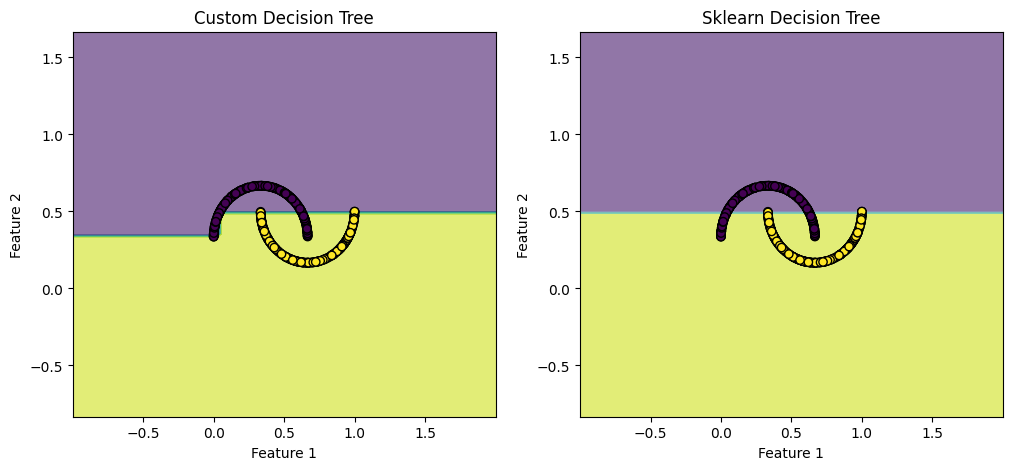

Own implementation results:
Accuracy: 0.91, Sensivity: 1.00, Specifity: 0.83
Sklearn implementation results:
Accuracy: 0.83, Sensivity: 1.00, Specifity: 0.66


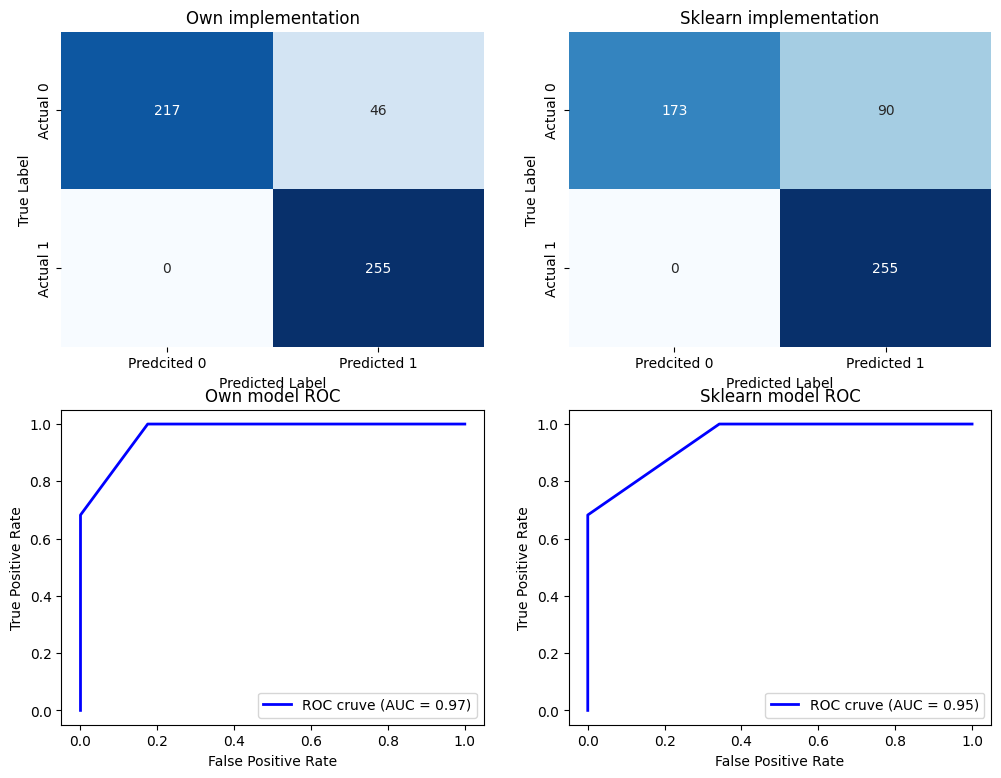

In [37]:
# Fitting models
sklearn_tree_clf = DecisionTreeClassifier(criterion='log_loss', max_depth=2)
sklearn_tree_clf.fit(dataset_moons.X_train, dataset_moons.y_train)

tree_clf = DecisionTree(max_depth=2)
tree_clf.fit(dataset_moons.X_train, dataset_moons.y_train)

# Own algorithm 
start_time = time.time()
for _ in range(100):
    y_pred = tree_clf.predict(dataset_moons.X_test)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Own Algorithm took {elapsed_time:.2f} sec")
y_proba = tree_clf.predict_proba(dataset_moons.X_test)[:, 1]

# Sklearn algorithm
start_time = time.time()
for _ in range(100):
    y_pred_sklearn = sklearn_tree_clf.predict(dataset_moons.X_test)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Sklearn Algorithm took {elapsed_time:.2f} sec")
y_proba_sklearn = sklearn_tree_clf.predict_proba(dataset_moons.X_test)[:, 1]


# Range of features
x_min, x_max = dataset_moons.X_test[:,0].min() - 1, dataset_moons.X_test[:,0].max() + 1 
y_min, y_max = dataset_moons.X_test[:,1].min() - 1, dataset_moons.X_test[:,1].max() + 1

# Creating mesh grid
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

# Flatten a mesh grid
grid_points = np.c_[xx.ravel(), yy.ravel()]

# Prediction for every point of the grid, own algorithm
Z = tree_clf.predict(grid_points)
Z = Z.reshape(xx.shape)

# Prediction for every point of the grid, sklearn algorithm
Z_sklearn = sklearn_tree_clf.predict(grid_points)
Z_sklearn = Z_sklearn.reshape(xx.shape)

# Create a figure with two subplots side by side
fig = plt.figure(figsize=(12, 5))
gs = GridSpec(1, 2, figure=fig)

# Plot own Decision Tree
ax1 = fig.add_subplot(gs[0, 0])
contour1 = ax1.contourf(xx, yy, Z, cmap="viridis", alpha=0.6)
scatter1 = ax1.scatter(dataset_moons.X_test[:, 0], dataset_moons.X_test[:, 1], c=dataset_moons.y_test, cmap="viridis", edgecolor='k')
ax1.set_xlabel("Feature 1")
ax1.set_ylabel("Feature 2")
ax1.set_title("Custom Decision Tree")

# Plot sklearn Decision Tree
ax2 = fig.add_subplot(gs[0, 1])
contour2 = ax2.contourf(xx, yy, Z_sklearn, cmap="viridis", alpha=0.6)
scatter2 = ax2.scatter(dataset_moons.X_test[:, 0], dataset_moons.X_test[:, 1], c=dataset_moons.y_test, cmap="viridis", edgecolor='k')
ax2.set_xlabel("Feature 1")
ax2.set_ylabel("Feature 2")
ax2.set_title("Sklearn Decision Tree")

plt.show()


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,9))

# Own analyzer
analyzer = ResultsAnalyzes(dataset_moons.y_test, y_pred)
print("Own implementation results:")
analyzer.show_results()
analyzer.confusion_matrix(ax=ax1, title="Own implementation")
analyzer.plot_ROC_curve(y_proba, ax=ax3, title="Own model ROC")

# Sklearn analyzer
analyzer_sklearn = ResultsAnalyzes(dataset_moons.y_test, y_pred_sklearn)
print("Sklearn implementation results:")
analyzer_sklearn.show_results()
analyzer_sklearn.confusion_matrix(ax=ax2, title="Sklearn implementation")
analyzer_sklearn.plot_ROC_curve(y_proba_sklearn, ax=ax4, title="Sklearn model ROC")

### 3.2.2. Depth of tree = n_clusters

Own Algorithm took 0.32 sec
Sklearn Algorithm took 0.01 sec


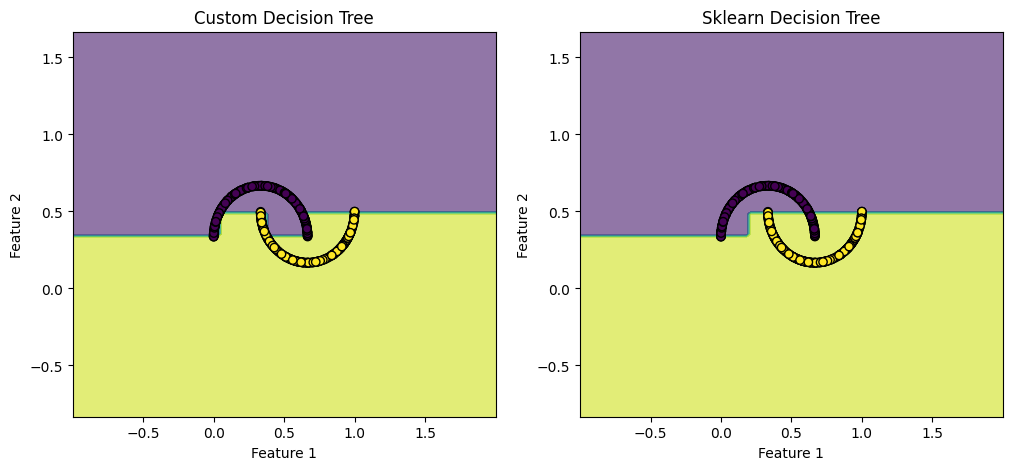

Own implementation results:
Accuracy: 1.00, Sensivity: 1.00, Specifity: 1.00
Sklearn implementation results:
Accuracy: 0.91, Sensivity: 1.00, Specifity: 0.83


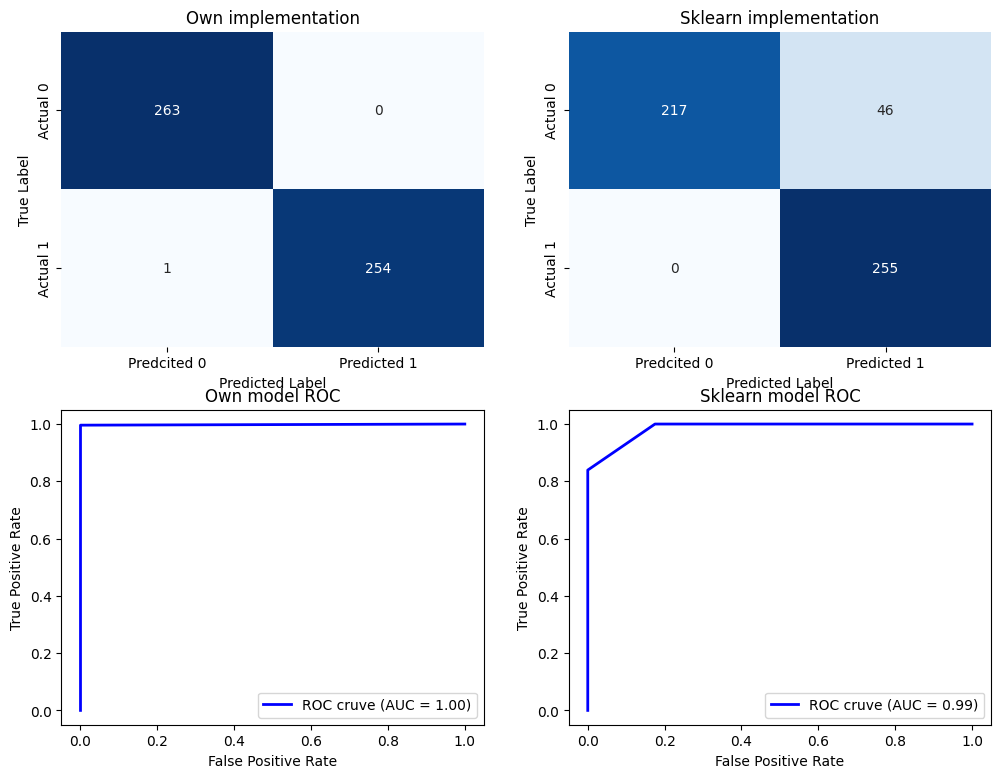

In [38]:
# Fitting models
sklearn_tree_clf = DecisionTreeClassifier(criterion='log_loss', max_depth=4)
sklearn_tree_clf.fit(dataset_moons.X_train, dataset_moons.y_train)

tree_clf = DecisionTree(max_depth=4)
tree_clf.fit(dataset_moons.X_train, dataset_moons.y_train)

# Own algorithm 
start_time = time.time()
for _ in range(100):
    y_pred = tree_clf.predict(dataset_moons.X_test)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Own Algorithm took {elapsed_time:.2f} sec")
y_proba = tree_clf.predict_proba(dataset_moons.X_test)[:, 1]

# Sklearn algorithm
start_time = time.time()
for _ in range(100):
    y_pred_sklearn = sklearn_tree_clf.predict(dataset_moons.X_test)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Sklearn Algorithm took {elapsed_time:.2f} sec")
y_proba_sklearn = sklearn_tree_clf.predict_proba(dataset_moons.X_test)[:, 1]


# Range of features
x_min, x_max = dataset_moons.X_test[:,0].min() - 1, dataset_moons.X_test[:,0].max() + 1 
y_min, y_max = dataset_moons.X_test[:,1].min() - 1, dataset_moons.X_test[:,1].max() + 1

# Creating mesh grid
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

# Flatten a mesh grid
grid_points = np.c_[xx.ravel(), yy.ravel()]

# Prediction for every point of the grid, own algorithm
Z = tree_clf.predict(grid_points)
Z = Z.reshape(xx.shape)

# Prediction for every point of the grid, sklearn algorithm
Z_sklearn = sklearn_tree_clf.predict(grid_points)
Z_sklearn = Z_sklearn.reshape(xx.shape)

# Create a figure with two subplots side by side
fig = plt.figure(figsize=(12, 5))
gs = GridSpec(1, 2, figure=fig)

# Plot own Decision Tree
ax1 = fig.add_subplot(gs[0, 0])
contour1 = ax1.contourf(xx, yy, Z, cmap="viridis", alpha=0.6)
scatter1 = ax1.scatter(dataset_moons.X_test[:, 0], dataset_moons.X_test[:, 1], c=dataset_moons.y_test, cmap="viridis", edgecolor='k')
ax1.set_xlabel("Feature 1")
ax1.set_ylabel("Feature 2")
ax1.set_title("Custom Decision Tree")

# Plot sklearn Decision Tree
ax2 = fig.add_subplot(gs[0, 1])
contour2 = ax2.contourf(xx, yy, Z_sklearn, cmap="viridis", alpha=0.6)
scatter2 = ax2.scatter(dataset_moons.X_test[:, 0], dataset_moons.X_test[:, 1], c=dataset_moons.y_test, cmap="viridis", edgecolor='k')
ax2.set_xlabel("Feature 1")
ax2.set_ylabel("Feature 2")
ax2.set_title("Sklearn Decision Tree")

plt.show()


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,9))

# Own analyzer
analyzer = ResultsAnalyzes(dataset_moons.y_test, y_pred)
print("Own implementation results:")
analyzer.show_results()
analyzer.confusion_matrix(ax=ax1, title="Own implementation")
analyzer.plot_ROC_curve(y_proba, ax=ax3, title="Own model ROC")

# Sklearn analyzer
analyzer_sklearn = ResultsAnalyzes(dataset_moons.y_test, y_pred_sklearn)
print("Sklearn implementation results:")
analyzer_sklearn.show_results()
analyzer_sklearn.confusion_matrix(ax=ax2, title="Sklearn implementation")
analyzer_sklearn.plot_ROC_curve(y_proba_sklearn, ax=ax4, title="Sklearn model ROC")

### 3.2.3. Depth of tree = non limited

Own Algorithm took 0.45 sec
Sklearn Algorithm took 0.01 sec


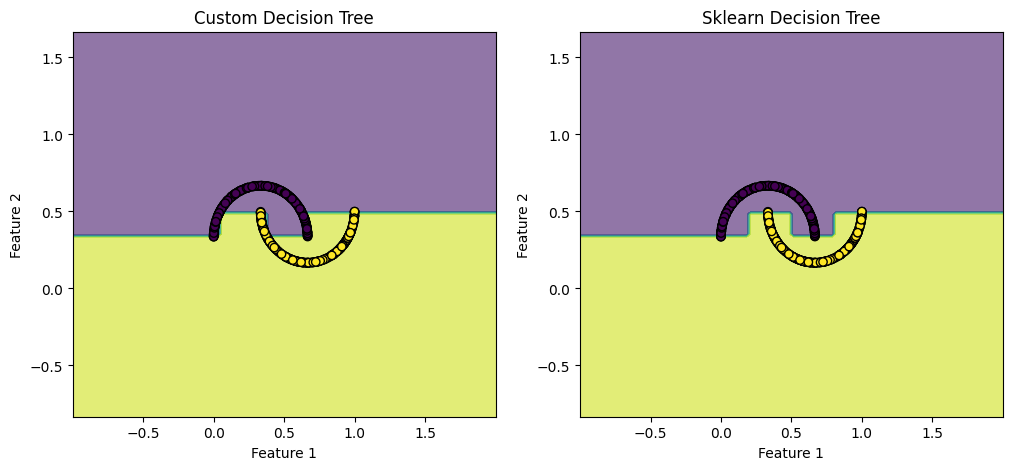

Own implementation results:
Accuracy: 1.00, Sensivity: 1.00, Specifity: 1.00
Sklearn implementation results:
Accuracy: 1.00, Sensivity: 1.00, Specifity: 1.00


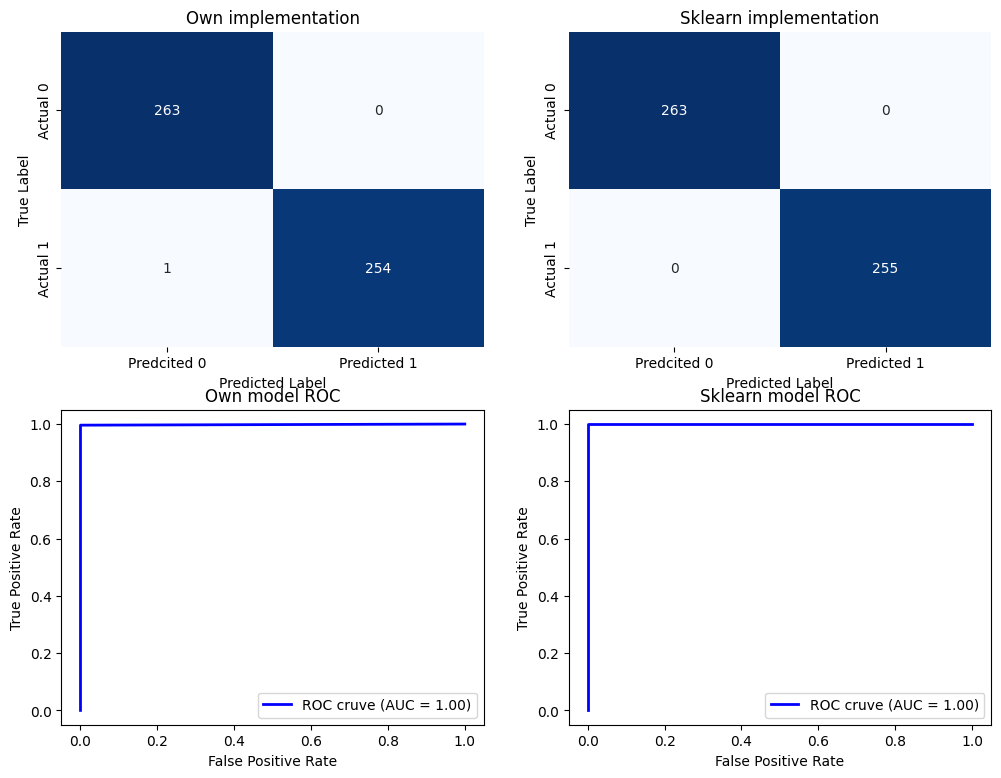

In [39]:
# Fitting models
sklearn_tree_clf = DecisionTreeClassifier(criterion='log_loss', max_depth=None)
sklearn_tree_clf.fit(dataset_moons.X_train, dataset_moons.y_train)

tree_clf = DecisionTree(max_depth=None)
tree_clf.fit(dataset_moons.X_train, dataset_moons.y_train)

# Own algorithm 
start_time = time.time()
for _ in range(100):
    y_pred = tree_clf.predict(dataset_moons.X_test)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Own Algorithm took {elapsed_time:.2f} sec")
y_proba = tree_clf.predict_proba(dataset_moons.X_test)[:, 1]

# Sklearn algorithm
start_time = time.time()
for _ in range(100):
    y_pred_sklearn = sklearn_tree_clf.predict(dataset_moons.X_test)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Sklearn Algorithm took {elapsed_time:.2f} sec")
y_proba_sklearn = sklearn_tree_clf.predict_proba(dataset_moons.X_test)[:, 1]


# Range of features
x_min, x_max = dataset_moons.X_test[:,0].min() - 1, dataset_moons.X_test[:,0].max() + 1 
y_min, y_max = dataset_moons.X_test[:,1].min() - 1, dataset_moons.X_test[:,1].max() + 1

# Creating mesh grid
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

# Flatten a mesh grid
grid_points = np.c_[xx.ravel(), yy.ravel()]

# Prediction for every point of the grid, own algorithm
Z = tree_clf.predict(grid_points)
Z = Z.reshape(xx.shape)

# Prediction for every point of the grid, sklearn algorithm
Z_sklearn = sklearn_tree_clf.predict(grid_points)
Z_sklearn = Z_sklearn.reshape(xx.shape)

# Create a figure with two subplots side by side
fig = plt.figure(figsize=(12, 5))
gs = GridSpec(1, 2, figure=fig)

# Plot own Decision Tree
ax1 = fig.add_subplot(gs[0, 0])
contour1 = ax1.contourf(xx, yy, Z, cmap="viridis", alpha=0.6)
scatter1 = ax1.scatter(dataset_moons.X_test[:, 0], dataset_moons.X_test[:, 1], c=dataset_moons.y_test, cmap="viridis", edgecolor='k')
ax1.set_xlabel("Feature 1")
ax1.set_ylabel("Feature 2")
ax1.set_title("Custom Decision Tree")

# Plot sklearn Decision Tree
ax2 = fig.add_subplot(gs[0, 1])
contour2 = ax2.contourf(xx, yy, Z_sklearn, cmap="viridis", alpha=0.6)
scatter2 = ax2.scatter(dataset_moons.X_test[:, 0], dataset_moons.X_test[:, 1], c=dataset_moons.y_test, cmap="viridis", edgecolor='k')
ax2.set_xlabel("Feature 1")
ax2.set_ylabel("Feature 2")
ax2.set_title("Sklearn Decision Tree")

plt.show()


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,9))

# Own analyzer
analyzer = ResultsAnalyzes(dataset_moons.y_test, y_pred)
print("Own implementation results:")
analyzer.show_results()
analyzer.confusion_matrix(ax=ax1, title="Own implementation")
analyzer.plot_ROC_curve(y_proba, ax=ax3, title="Own model ROC")

# Sklearn analyzer
analyzer_sklearn = ResultsAnalyzes(dataset_moons.y_test, y_pred_sklearn)
print("Sklearn implementation results:")
analyzer_sklearn.show_results()
analyzer_sklearn.confusion_matrix(ax=ax2, title="Sklearn implementation")
analyzer_sklearn.plot_ROC_curve(y_proba_sklearn, ax=ax4, title="Sklearn model ROC")

## 3.3. Make classification, multimodal set

In [40]:
N_CLUSTERS_PER_CLASS = 2
CLASS_SEP = 2.0
N_INFORMATIVE = 2
N_FEATURES = 2
dataset_multimodal = SyntheticDataset(RANDOM_STATE, N_SAMPLES, N_FEATURES, N_CLASSES, N_INFORMATIVE, N_CLUSTERS_PER_CLASS, CLASS_SEP)
dataset_multimodal.generate_make_classification() 

# Dividing dataset on a trening set and test set 
dataset_multimodal.splitting()

# Normalization of datasets 
dataset_multimodal.normalize()

(array([[0.71923928, 0.63980178],
        [0.3131077 , 0.7154171 ],
        [0.3081684 , 0.69758695],
        ...,
        [0.73632932, 0.15591902],
        [0.63589136, 0.29442939],
        [0.60741561, 0.34472042]], shape=(2069, 2)),
 array([[0.73827388, 0.20861565],
        [0.59067869, 0.57424748],
        [0.31963692, 0.3398298 ],
        ...,
        [0.58911862, 0.27449148],
        [0.29492699, 0.65186354],
        [0.30275551, 0.2907929 ]], shape=(518, 2)))

### 3.3.1. Depth of tree = n_features

Own Algorithm took 0.38 sec
Sklearn Algorithm took 0.01 sec


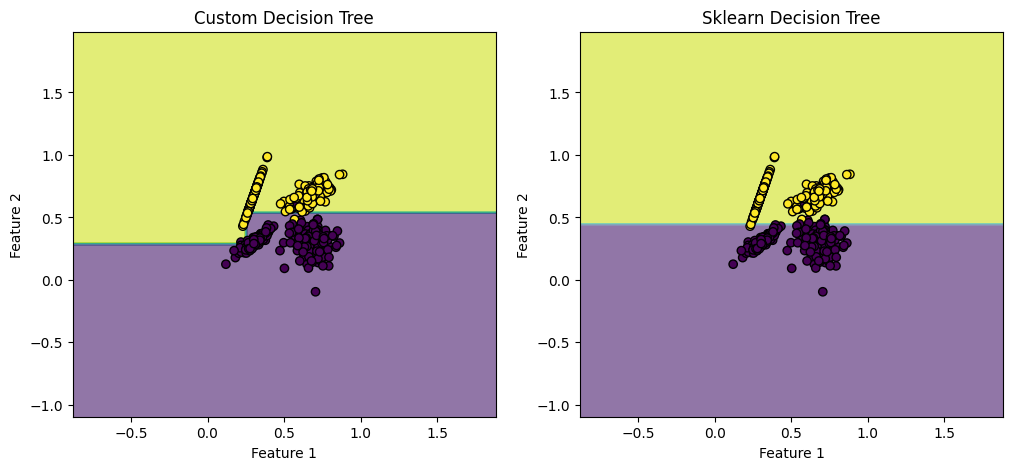

Own implementation results:
Accuracy: 0.99, Sensivity: 1.00, Specifity: 0.99
Sklearn implementation results:
Accuracy: 0.98, Sensivity: 0.99, Specifity: 0.98


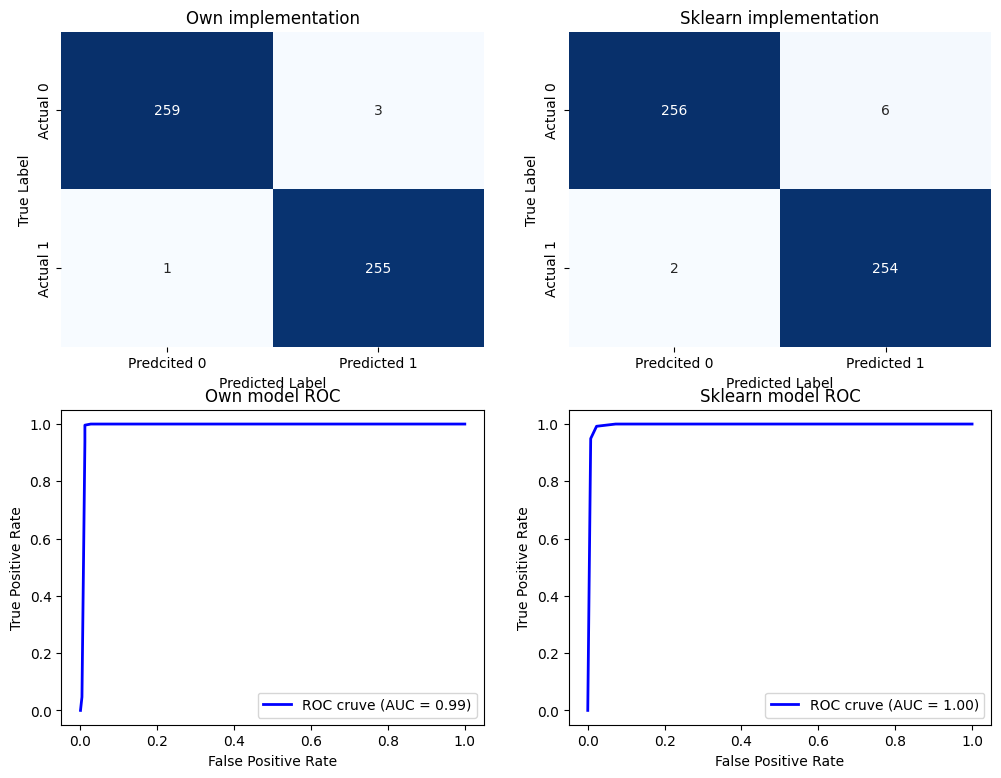

In [41]:
# Fitting models
sklearn_tree_clf = DecisionTreeClassifier(criterion='log_loss', max_depth=2)
sklearn_tree_clf.fit(dataset_multimodal.X_train, dataset_multimodal.y_train)

tree_clf = DecisionTree(max_depth=2)
tree_clf.fit(dataset_multimodal.X_train, dataset_multimodal.y_train)

# Own algorithm 
start_time = time.time()
for _ in range(100):
    y_pred = tree_clf.predict(dataset_multimodal.X_test)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Own Algorithm took {elapsed_time:.2f} sec")
y_proba = tree_clf.predict_proba(dataset_multimodal.X_test)[:, 1]

# Sklearn algorithm
start_time = time.time()
for _ in range(100):
    y_pred_sklearn = sklearn_tree_clf.predict(dataset_multimodal.X_test)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Sklearn Algorithm took {elapsed_time:.2f} sec")
y_proba_sklearn = sklearn_tree_clf.predict_proba(dataset_multimodal.X_test)[:, 1]


# Range of features
x_min, x_max = dataset_multimodal.X_test[:,0].min() - 1, dataset_multimodal.X_test[:,0].max() + 1 
y_min, y_max = dataset_multimodal.X_test[:,1].min() - 1, dataset_multimodal.X_test[:,1].max() + 1

# Creating mesh grid
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

# Flatten a mesh grid
grid_points = np.c_[xx.ravel(), yy.ravel()]

# Prediction for every point of the grid, own algorithm
Z = tree_clf.predict(grid_points)
Z = Z.reshape(xx.shape)

# Prediction for every point of the grid, sklearn algorithm
Z_sklearn = sklearn_tree_clf.predict(grid_points)
Z_sklearn = Z_sklearn.reshape(xx.shape)

# Create a figure with two subplots side by side
fig = plt.figure(figsize=(12, 5))
gs = GridSpec(1, 2, figure=fig)

# Plot own Decision Tree
ax1 = fig.add_subplot(gs[0, 0])
contour1 = ax1.contourf(xx, yy, Z, cmap="viridis", alpha=0.6)
scatter1 = ax1.scatter(dataset_multimodal.X_test[:, 0], dataset_multimodal.X_test[:, 1], c=dataset_multimodal.y_test, cmap="viridis", edgecolor='k')
ax1.set_xlabel("Feature 1")
ax1.set_ylabel("Feature 2")
ax1.set_title("Custom Decision Tree")

# Plot sklearn Decision Tree
ax2 = fig.add_subplot(gs[0, 1])
contour2 = ax2.contourf(xx, yy, Z_sklearn, cmap="viridis", alpha=0.6)
scatter2 = ax2.scatter(dataset_multimodal.X_test[:, 0], dataset_multimodal.X_test[:, 1], c=dataset_multimodal.y_test, cmap="viridis", edgecolor='k')
ax2.set_xlabel("Feature 1")
ax2.set_ylabel("Feature 2")
ax2.set_title("Sklearn Decision Tree")

plt.show()


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,9))

# Own analyzer
analyzer = ResultsAnalyzes(dataset_multimodal.y_test, y_pred)
print("Own implementation results:")
analyzer.show_results()
analyzer.confusion_matrix(ax=ax1, title="Own implementation")
analyzer.plot_ROC_curve(y_proba, ax=ax3, title="Own model ROC")

# Sklearn analyzer
analyzer_sklearn = ResultsAnalyzes(dataset_multimodal.y_test, y_pred_sklearn)
print("Sklearn implementation results:")
analyzer_sklearn.show_results()
analyzer_sklearn.confusion_matrix(ax=ax2, title="Sklearn implementation")
analyzer_sklearn.plot_ROC_curve(y_proba_sklearn, ax=ax4, title="Sklearn model ROC")

### 3.3.2. Depth of tree = n_clusters

Own Algorithm took 0.36 sec
Sklearn Algorithm took 0.01 sec


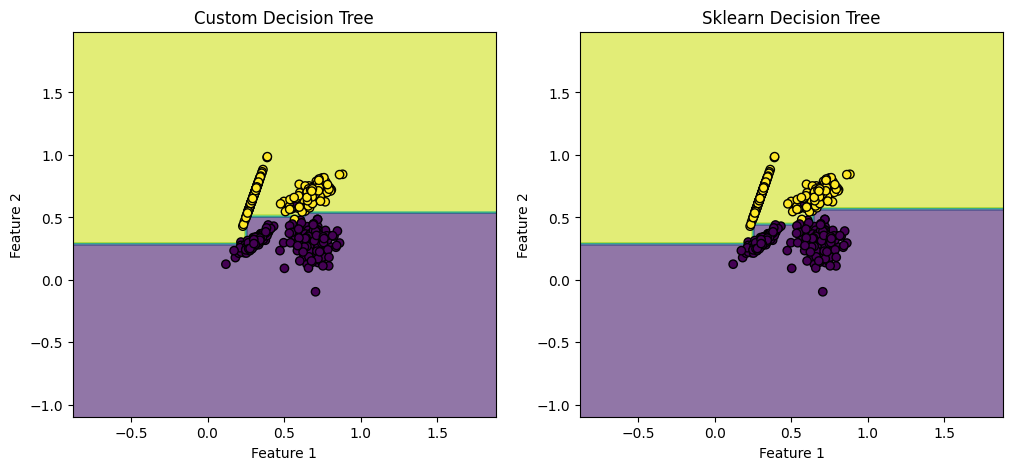

Own implementation results:
Accuracy: 0.99, Sensivity: 1.00, Specifity: 0.99
Sklearn implementation results:
Accuracy: 0.99, Sensivity: 1.00, Specifity: 0.98


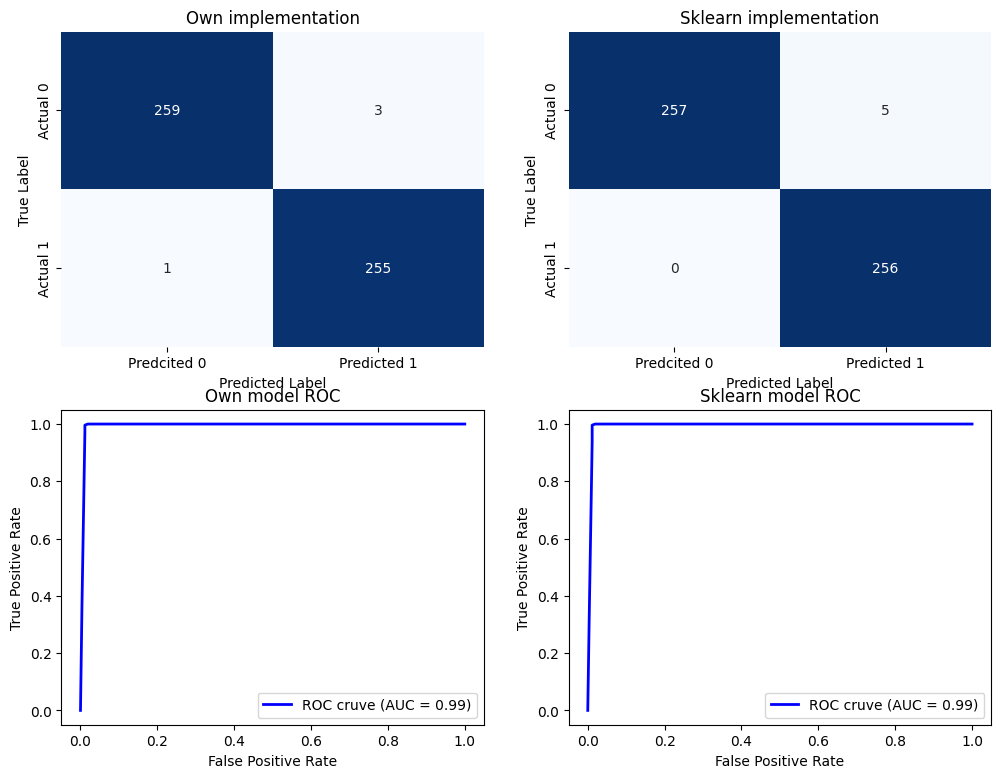

In [42]:
# Fitting models
sklearn_tree_clf = DecisionTreeClassifier(criterion='log_loss', max_depth=4)
sklearn_tree_clf.fit(dataset_multimodal.X_train, dataset_multimodal.y_train)

tree_clf = DecisionTree(max_depth=4)
tree_clf.fit(dataset_multimodal.X_train, dataset_multimodal.y_train)

# Own algorithm 
start_time = time.time()
for _ in range(100):
    y_pred = tree_clf.predict(dataset_multimodal.X_test)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Own Algorithm took {elapsed_time:.2f} sec")
y_proba = tree_clf.predict_proba(dataset_multimodal.X_test)[:, 1]

# Sklearn algorithm
start_time = time.time()
for _ in range(100):
    y_pred_sklearn = sklearn_tree_clf.predict(dataset_multimodal.X_test)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Sklearn Algorithm took {elapsed_time:.2f} sec")
y_proba_sklearn = sklearn_tree_clf.predict_proba(dataset_multimodal.X_test)[:, 1]


# Range of features
x_min, x_max = dataset_multimodal.X_test[:,0].min() - 1, dataset_multimodal.X_test[:,0].max() + 1 
y_min, y_max = dataset_multimodal.X_test[:,1].min() - 1, dataset_multimodal.X_test[:,1].max() + 1

# Creating mesh grid
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

# Flatten a mesh grid
grid_points = np.c_[xx.ravel(), yy.ravel()]

# Prediction for every point of the grid, own algorithm
Z = tree_clf.predict(grid_points)
Z = Z.reshape(xx.shape)

# Prediction for every point of the grid, sklearn algorithm
Z_sklearn = sklearn_tree_clf.predict(grid_points)
Z_sklearn = Z_sklearn.reshape(xx.shape)

# Create a figure with two subplots side by side
fig = plt.figure(figsize=(12, 5))
gs = GridSpec(1, 2, figure=fig)

# Plot own Decision Tree
ax1 = fig.add_subplot(gs[0, 0])
contour1 = ax1.contourf(xx, yy, Z, cmap="viridis", alpha=0.6)
scatter1 = ax1.scatter(dataset_multimodal.X_test[:, 0], dataset_multimodal.X_test[:, 1], c=dataset_multimodal.y_test, cmap="viridis", edgecolor='k')
ax1.set_xlabel("Feature 1")
ax1.set_ylabel("Feature 2")
ax1.set_title("Custom Decision Tree")

# Plot sklearn Decision Tree
ax2 = fig.add_subplot(gs[0, 1])
contour2 = ax2.contourf(xx, yy, Z_sklearn, cmap="viridis", alpha=0.6)
scatter2 = ax2.scatter(dataset_multimodal.X_test[:, 0], dataset_multimodal.X_test[:, 1], c=dataset_multimodal.y_test, cmap="viridis", edgecolor='k')
ax2.set_xlabel("Feature 1")
ax2.set_ylabel("Feature 2")
ax2.set_title("Sklearn Decision Tree")

plt.show()


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,9))

# Own analyzer
analyzer = ResultsAnalyzes(dataset_multimodal.y_test, y_pred)
print("Own implementation results:")
analyzer.show_results()
analyzer.confusion_matrix(ax=ax1, title="Own implementation")
analyzer.plot_ROC_curve(y_proba, ax=ax3, title="Own model ROC")

# Sklearn analyzer
analyzer_sklearn = ResultsAnalyzes(dataset_multimodal.y_test, y_pred_sklearn)
print("Sklearn implementation results:")
analyzer_sklearn.show_results()
analyzer_sklearn.confusion_matrix(ax=ax2, title="Sklearn implementation")
analyzer_sklearn.plot_ROC_curve(y_proba_sklearn, ax=ax4, title="Sklearn model ROC")

### 3.3.3. Depth of tree = non limited

Own Algorithm took 0.44 sec
Sklearn Algorithm took 0.01 sec


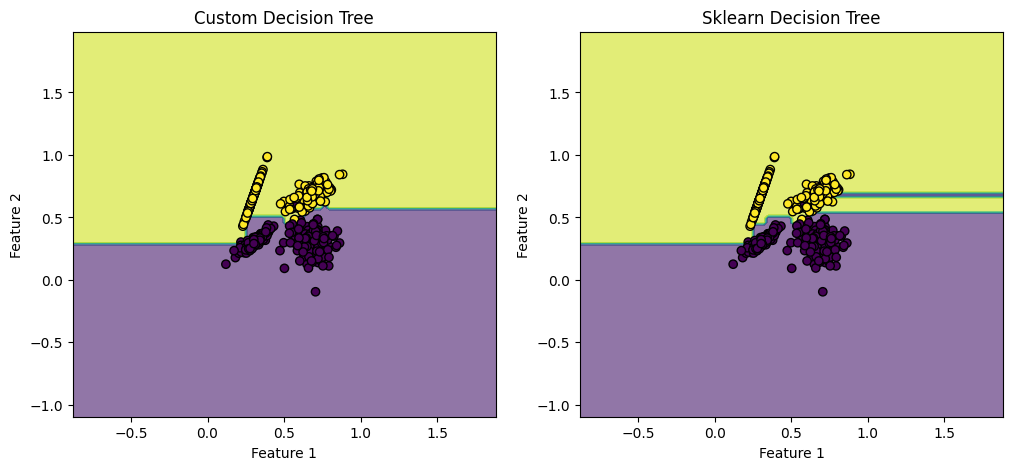

Own implementation results:
Accuracy: 0.99, Sensivity: 0.99, Specifity: 0.99
Sklearn implementation results:
Accuracy: 0.99, Sensivity: 1.00, Specifity: 0.99


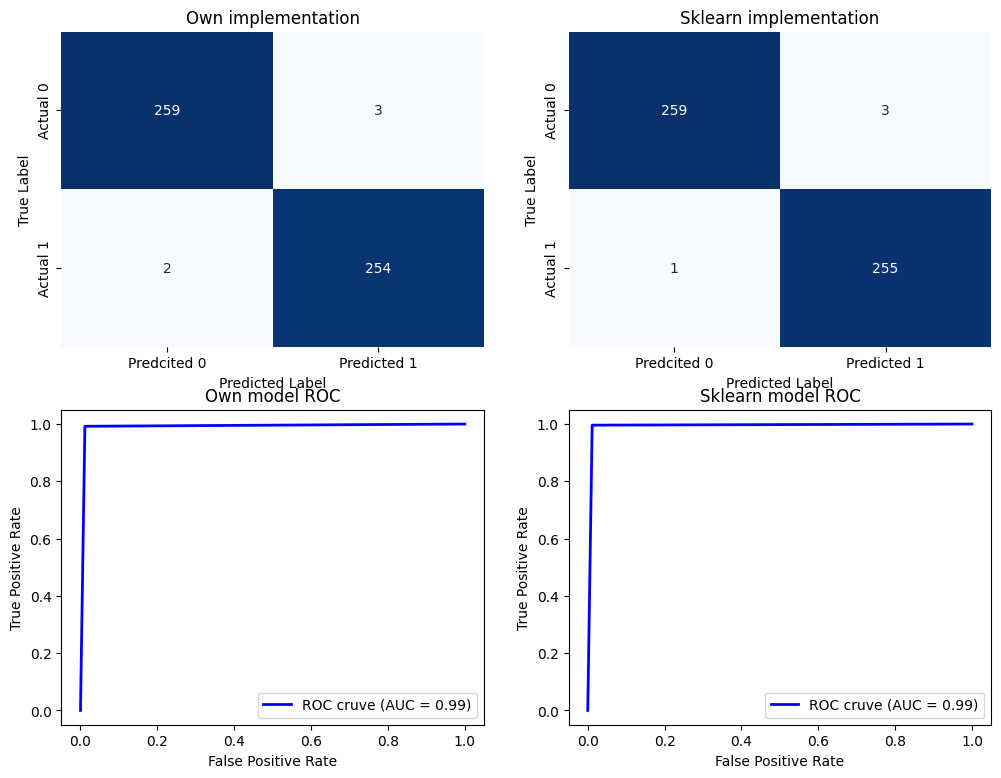

In [43]:
# Fitting models
sklearn_tree_clf = DecisionTreeClassifier(criterion='log_loss', max_depth=None)
sklearn_tree_clf.fit(dataset_multimodal.X_train, dataset_multimodal.y_train)

tree_clf = DecisionTree(max_depth=None)
tree_clf.fit(dataset_multimodal.X_train, dataset_multimodal.y_train)

# Own algorithm 
start_time = time.time()
for _ in range(100):
    y_pred = tree_clf.predict(dataset_multimodal.X_test)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Own Algorithm took {elapsed_time:.2f} sec")
y_proba = tree_clf.predict_proba(dataset_multimodal.X_test)[:, 1]

# Sklearn algorithm
start_time = time.time()
for _ in range(100):
    y_pred_sklearn = sklearn_tree_clf.predict(dataset_multimodal.X_test)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Sklearn Algorithm took {elapsed_time:.2f} sec")
y_proba_sklearn = sklearn_tree_clf.predict_proba(dataset_multimodal.X_test)[:, 1]


# Range of features
x_min, x_max = dataset_multimodal.X_test[:,0].min() - 1, dataset_multimodal.X_test[:,0].max() + 1 
y_min, y_max = dataset_multimodal.X_test[:,1].min() - 1, dataset_multimodal.X_test[:,1].max() + 1

# Creating mesh grid
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

# Flatten a mesh grid
grid_points = np.c_[xx.ravel(), yy.ravel()]

# Prediction for every point of the grid, own algorithm
Z = tree_clf.predict(grid_points)
Z = Z.reshape(xx.shape)

# Prediction for every point of the grid, sklearn algorithm
Z_sklearn = sklearn_tree_clf.predict(grid_points)
Z_sklearn = Z_sklearn.reshape(xx.shape)

# Create a figure with two subplots side by side
fig = plt.figure(figsize=(12, 5))
gs = GridSpec(1, 2, figure=fig)

# Plot own Decision Tree
ax1 = fig.add_subplot(gs[0, 0])
contour1 = ax1.contourf(xx, yy, Z, cmap="viridis", alpha=0.6)
scatter1 = ax1.scatter(dataset_multimodal.X_test[:, 0], dataset_multimodal.X_test[:, 1], c=dataset_multimodal.y_test, cmap="viridis", edgecolor='k')
ax1.set_xlabel("Feature 1")
ax1.set_ylabel("Feature 2")
ax1.set_title("Custom Decision Tree")

# Plot sklearn Decision Tree
ax2 = fig.add_subplot(gs[0, 1])
contour2 = ax2.contourf(xx, yy, Z_sklearn, cmap="viridis", alpha=0.6)
scatter2 = ax2.scatter(dataset_multimodal.X_test[:, 0], dataset_multimodal.X_test[:, 1], c=dataset_multimodal.y_test, cmap="viridis", edgecolor='k')
ax2.set_xlabel("Feature 1")
ax2.set_ylabel("Feature 2")
ax2.set_title("Sklearn Decision Tree")

plt.show()


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,9))

# Own analyzer
analyzer = ResultsAnalyzes(dataset_multimodal.y_test, y_pred)
print("Own implementation results:")
analyzer.show_results()
analyzer.confusion_matrix(ax=ax1, title="Own implementation")
analyzer.plot_ROC_curve(y_proba, ax=ax3, title="Own model ROC")

# Sklearn analyzer
analyzer_sklearn = ResultsAnalyzes(dataset_multimodal.y_test, y_pred_sklearn)
print("Sklearn implementation results:")
analyzer_sklearn.show_results()
analyzer_sklearn.confusion_matrix(ax=ax2, title="Sklearn implementation")
analyzer_sklearn.plot_ROC_curve(y_proba_sklearn, ax=ax4, title="Sklearn model ROC")

# 4.0 Import database HTRU2

In [44]:
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import MinMaxScaler

file = pd.read_csv('HTRU_2.csv')
file.head()

X = file.iloc[:,:-1].values
y = file.iloc[:, -1].values

# Splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

# Winsorize training dataset
X_train = winsorize(X_train, limits=[0.05, 0.05])

# Clipping test data
X_test = np.clip(X_test, a_min=np.min(X_train, axis=0), a_max=np.max(X_train, axis=0)) # axis=0 operates column-wise

# Normalizing
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 4.1. Grid Search 

In [45]:
sklearn_tree_clf = DecisionTreeClassifier()
parameters = {'criterion':['gini', 'entropy', 'log_loss'],
                'max_depth': [None, 3, 5, 7], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
clf = GridSearchCV(sklearn_tree_clf, parameters)
clf.fit(X_train, y_train)

GridSearchCV(
    estimator=DecisionTreeClassifier(),
    param_grid={'criterion':['gini', 'entropy', 'log_loss'],
                'max_depth': [None, 3, 5, 7], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]})

print(clf.best_params_)
print(clf.best_score_)


{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10}
0.9777887349090788


# 5.0 Max Depth's impact on inference and accuracy

Current depth 2
Current depth 4
Current depth 6
Current depth 8


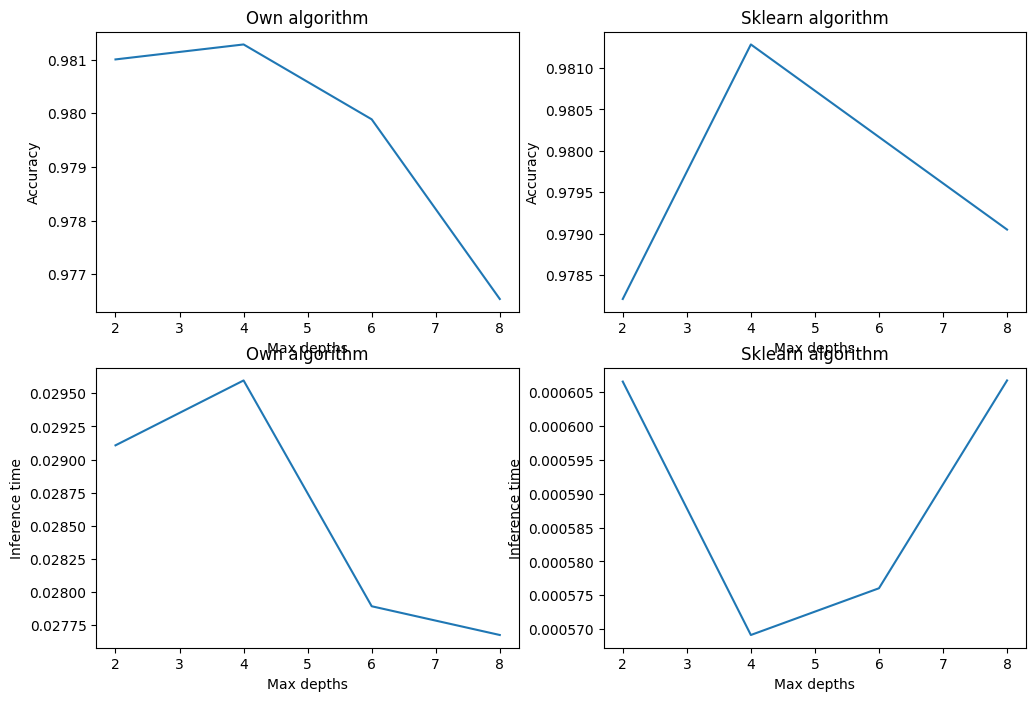

In [46]:
from sklearn.metrics import accuracy_score

max_depths = range(2, 10, 2)
accuracies = []
sklearn_accuracies = []
inference_times = []
sklearn_inference_times = []

for depth in max_depths:
    print(f"Current depth {depth}")
    # Fitting models
    sklearn_tree_clf = DecisionTreeClassifier(criterion='entropy', max_depth=depth)
    sklearn_tree_clf.fit(X_train, y_train)

    tree_clf = DecisionTree(max_depth=depth)
    tree_clf.fit(X_train, y_train)

    # Own algorithm 
    start_time = time.time()
    acc = 0
    for _ in range(10):
        y_pred = tree_clf.predict(X_test)
        acc += accuracy_score(y_test, y_pred)
    end_time = time.time()
    elapsed_time = (end_time - start_time) / 10
    inference_times.append(elapsed_time)
    mean_acc = acc / 10
    accuracies.append(mean_acc)

    # Sklearn algorithm
    start_time = time.time()
    acc = 0
    for _ in range(10):
        y_pred_sklearn = sklearn_tree_clf.predict(X_test)
        acc += accuracy_score(y_test, y_pred_sklearn)
    end_time = time.time()
    elapsed_time = (end_time - start_time) / 10
    sklearn_inference_times.append(elapsed_time)
    mean_acc = acc / 10
    sklearn_accuracies.append(mean_acc)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(12,8))

ax1.plot(max_depths, accuracies)
ax1.set_xlabel("Max depths")
ax1.set_ylabel("Accuracy")
ax1.set_title("Own algorithm")

ax2.plot(max_depths, sklearn_accuracies)
ax2.set_xlabel("Max depths")
ax2.set_ylabel("Accuracy")
ax2.set_title("Sklearn algorithm")

ax3.plot(max_depths, inference_times)
ax3.set_xlabel("Max depths")
ax3.set_ylabel("Inference time")
ax3.set_title("Own algorithm")

ax4.plot(max_depths, sklearn_inference_times)
ax4.set_xlabel("Max depths")
ax4.set_ylabel("Inference time")
ax4.set_title("Sklearn algorithm")

plt.show()

We can see that we got best accuracy score with max_depth = 4, for higher value of max_depth time of inference is rising. 